### Case Study - Pinchout and Fault Scenarios
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty

This notebook showcases how structural parameters, in this case CPz and fault_offset can be used to generate multiple structural models and address structural uncertainty in 3D groundwater models. This notebook contains the Pinchout and Fault Scenarios and use a synthetic example to explore uncertainty in pinchout location and fault geometry. 

In [104]:
import pandas as pd
import numpy as np
import math
import subprocess
import sys
import os
import pickle
import functions # This is a project specific python script saved in folder functions.py
    
sys.path.append('../../MODFLOW_Tools') # This is how to import MODFLOW TOOLS modules    
%run ./figures.ipynb                   # Contains functions to produce figures

%load_ext autoreload
%autoreload 2
logfunc = lambda e: np.log10(e)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
sys.path.append('../../MODFLOW_Tools')
from loop2flopy import Project
P = Project('showcase', boundingbox = [0, 6000, 0, 6000, -500, 0]) # (x0, x1, y0, y1, z0, z1)

# Spatial information
P.crs = "epsg:28350" # Put in coordinate reference
P.xypumpbores = []#(500,500), (1600, 2800), (5500,5500), (2800,1600)] 
P.npump = len(P.xypumpbores)
P.idpumpbores = [] 
P.xyobsbores = [(1500,1000), (2500, 5000), (4000, 3000), (5000,1500)]
P.idobsbores = ['OB1', 'OB2', 'OB3', 'OB4'] 
#P.geo_coords=[(500,500), (1600, 2800), (5500,5500), (2800,1600)]
#P.geo_bores = ['P1', 'P2', 'P3', 'P4']

# Observation Points
P.nobs = len(P.xyobsbores)
obs_z = [-40, -50, -100, -200, -300]
P.nzobs = len(obs_z)
P.zobs = np.ones((P.nobs, P.nzobs))
for j in range(P.nzobs):
    P.zobs[:, j] = P.zobs[:, j] * obs_z[j] 

# Meshing parameters
P.triExeName = '../exe/triangle.exe'
P.fx1, P.fy1, P.fx2, P.fy2 = (2000, 4500, 3000, 1000) # fault end points
P.fault_buffer = 150.  # offset boundary from fault
P.r = 40               # refining factor for model boundary. High r has refined edges
P.w = 150              # interior boundary offset
P.boundmaxtri = 50000  # max triangle area in boundary area
P.modelmaxtri = 50000  # max triangle area in main model area
P.angle = 32           # minimum triangle angles
P.radius1 = 100        # radius of inner circle around pumping bores
P.radius2 = 200        # radius of outer circle around pumping bores
P.boremaxtri = 100000   # max triangle area within bore radius

# Flow model parameters
P.mfexe_name = '../exe/mf6.exe'
P.workspace = '../modelfiles/'
P.nlg = 4    # number of geological layers
P.nls = 2    # number sublayers for conformable
P.nlv  = 30  # number of layers for voxel transect grid
P.min_modlay_thick = [50, 50, 50, 50]
P.res = 2    # vertical resolution upon which voxel grid created to pick lithology bottoms

P.ss = [0.00009, 0.00007, 0.00002, 0.00008]
P.sy = [0.12, 0.1, 0.1, 0.1]

P.rch = 0.4/365 # 0.0027 m/d
P.strt = -20.
P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20 # horizontal gradient of 0.01 and vertical gradient of 0.02
P.xt3d = True
   
vtk_workspace = '../vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(vtk_workspace, exist_ok=True)
    
if not os.path.isdir('../modelfiles'):
    os.makedirs(P.workspace, exist_ok=True)

In [106]:
from meshing_routines import createcell2d
P.obs_ref = 150
P.cell2dtri, P.xcyctri, P.verticestri, P.tri, trinodes = createcell2d(P, grid = 'tri', fault = True)  
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = True)  

[(150, 150), (5850, 150), (5850, 5850), (150, 5850)]


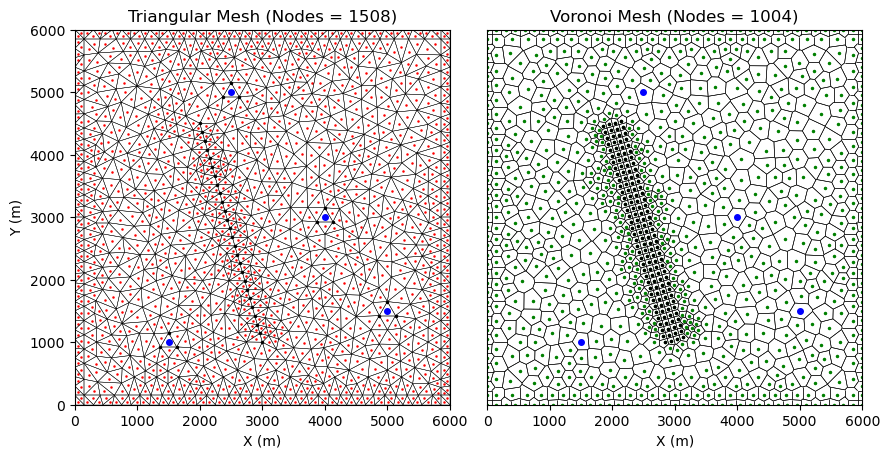

In [114]:
%run ./figures.ipynb                   # Contains functions to produce figures
figure3(P)

### Faults - 6 simulations

In [43]:
P.hk = [1, 2, 0.01, 5] 
P.vk = [i/10 for i in P.hk]

options = [0,50,120,150,200,250] # Fault displacement

data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "fault_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")

P.control_points = ([])
P.fault_max_disp = 100.    # Was 200
P.minor_axis = 1000        # Fault_influence - orthogonal to fault
P.fault_center = [P.fx1 + (P.fx2 - P.fx1)/2, P.fy1 + (P.fy2 - P.fy1)/2, -400]
P.fault_slip_vector=[0,0,1]
    
fault_modelnames, fault_models, fault_obs_heads = [],[],[]         

from loop2flopy import Model
for i in range(len(options)):
    fault_modelnames.append(str('FD_'+str(options[i])))  
    fault_models.append(Model(fault_modelnames[i], P, plan = 'vor', transect = 'con')) # Create flow model  
    P.fault_max_disp = options[i] 
    P.data, P.strat = functions.prepare_geomodel_loopshowcase(P, data, strat, include_fault = True)   # Prepare geomodel inputs
    P.geomodel = functions.create_geomodel_loopshowcase(P, include_fault = True) # Make geomodel
    M = fault_models[i]
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    results = M.write_run_model(P, period = 'Steady', ic_array = P.strt) 
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = results[0], results[1], results[2], results[-1]
    fault_obs_heads.append((functions.process_obs_steady(P, M)))
    f = os.path.join(vtk_workspace, "faults", M.modelname)
    M.gwf.export(f, fmt="vtk")

                          projected onto fault surface estimating from fault normal
C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
   Creating lithology and discretisation arrays for  FD_0  ...
   Creating property arrays for  FD_0  ...
   Adding flow packages to  FD_0  ...
   Time taken =  0.470025
   Writing simulation and gwf for  FD_0  ...
Period =  Steady 
   Model success =  True
   run_time =  6.483079


                          projected onto fault surface estimating from fault normal
C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
   Creating lithology and discretisation arrays for  FD_50  ...
   Creating property arrays for  FD_50  ...
   Adding flow packages to  FD_50  ...
   Time taken =  0.549935
   Writing simulation and gwf for  FD_50  ...
Period =  Steady 
   Model success =  True
   run_time =  6.75466


                          projected onto fault surface estimating from fault normal
C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
   Creating lithology and discretisation arrays for  FD_120  ...
   Creating property arrays for  FD_120  ...
   Adding flow packages to  FD_120  ...
   Time taken =  0.560249
   Writing simulation and gwf for  FD_120  ...
Period =  Steady 
   Model success =  True
   run_time =  6.650313


                          projected onto fault surface estimating from fault normal
C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
   Creating lithology and discretisation arrays for  FD_150  ...
   Creating property arrays for  FD_150  ...
   Adding flow packages to  FD_150  ...
   Time taken =  0.592265
   Writing simulation and gwf for  FD_150  ...
Period =  Steady 
   Model success =  True
   run_time =  6.84217


                          projected onto fault surface estimating from fault normal
C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
   Creating lithology and discretisation arrays for  FD_200  ...
   Creating property arrays for  FD_200  ...
   Adding flow packages to  FD_200  ...
   Time taken =  0.9736
   Writing simulation and gwf for  FD_200  ...
Period =  Steady 
   Model success =  True
   run_time =  7.842275


                          projected onto fault surface estimating from fault normal
C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
   Creating lithology and discretisation arrays for  FD_250  ...
   Creating property arrays for  FD_250  ...
   Adding flow packages to  FD_250  ...
   Time taken =  0.714231
   Writing simulation and gwf for  FD_250  ...
Period =  Steady 
   Model success =  True
   run_time =  6.916502


In [44]:
# PLOTS
#plot_bores(P)
#plot_observations(heads = fault_obs_heads, modelnames = fault_modelnames, ylim = [-40, -5])
#plot_bylayer(P, models = fault_models, layer = 2, vmin = -35, vmax = -10) 
#multiplot_vgrid_transect(P, models = fault_models, array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1)
#multiplot_prop_transect(P, models = fault_models, array = 'head_ss', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)

C:\Users\19904604\AppData\Local\Temp\ipykernel_13884\3735542499.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\19904604\AppData\Local\Temp\ipykernel_13884\3735542499.py:123: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


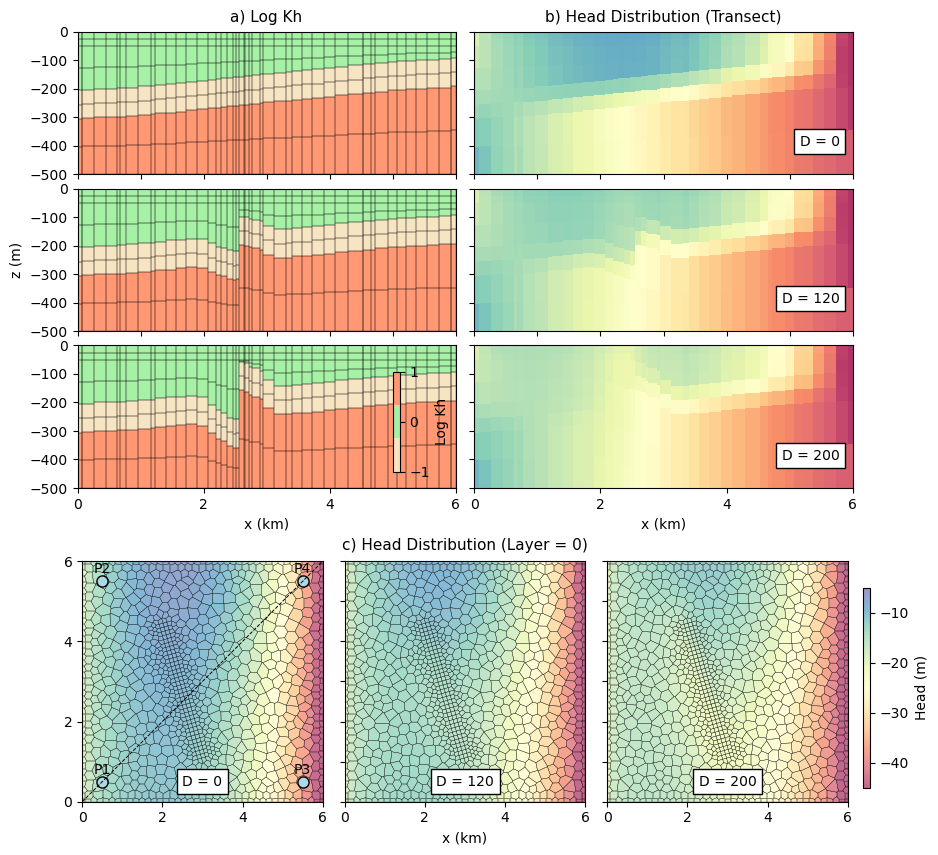

In [119]:
%run ./figures.ipynb
figure6(P, models = fault_models, X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,vmin = -45, vmax = -5)

### Pinchout - 6 simulations

In [46]:
P.hk = [1, 0.1, 10, 0.1] 
P.vk = [i/10 for i in P.hk]

#P.hk = [1.7, 0.07, 8.2, 0.5] 
#P.vk = [0.12,0.007,0.51,0.05] 

P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = False)    
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "pinchout_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")

options = np.linspace(-250, 0, 6) # control point z values

pinchout_modelnames, pinchout_models, pinchout_obs_heads = [],[],[]        
heads = []

for i in range(len(options)):
    pinchout_modelnames.append(str('PO_'+str(options[i])))  
    pinchout_models.append(Model(pinchout_modelnames[i], P, plan = 'vor', transect = 'con')) # Create flow model  
    P.control_points = (['CP1', 'control', 3000, 3000, options[i], -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
    
    P.data, P.strat = functions.prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = functions.create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M = pinchout_models[i]
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    results = M.write_run_model(P, period = 'Steady', ic_array = P.strt)   
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = results[0], results[1], results[2], results[-1]
    pinchout_obs_heads.append((functions.process_obs_steady(P, M)))
    heads.append((M.head_ss))
    f = os.path.join(vtk_workspace, "pinchouts", M.modelname)
    M.gwf.export(f, fmt="vtk")
    


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating lithology and discretisation arrays for  PO_-250.0  ...
   Creating property arrays for  PO_-250.0  ...
   Adding flow packages to  PO_-250.0  ...
   Time taken =  0.475718
   Writing simulation and gwf for  PO_-250.0  ...
Period =  Steady 
   Model success =  True
   run_time =  5.504569


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating lithology and discretisation arrays for  PO_-200.0  ...
   Creating property arrays for  PO_-200.0  ...
   Adding flow packages to  PO_-200.0  ...
   Time taken =  0.75325
   Writing simulation and gwf for  PO_-200.0  ...
Period =  Steady 
   Model success =  True
   run_time =  8.084868


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating lithology and discretisation arrays for  PO_-150.0  ...
   Creating property arrays for  PO_-150.0  ...
   Adding flow packages to  PO_-150.0  ...
   Time taken =  0.439084
   Writing simulation and gwf for  PO_-150.0  ...
Period =  Steady 
   Model success =  True
   run_time =  5.045518


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating lithology and discretisation arrays for  PO_-100.0  ...
   Creating property arrays for  PO_-100.0  ...
   Adding flow packages to  PO_-100.0  ...
   Time taken =  0.463815
   Writing simulation and gwf for  PO_-100.0  ...
Period =  Steady 
   Model success =  True
   run_time =  4.510009


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating lithology and discretisation arrays for  PO_-50.0  ...
   Creating property arrays for  PO_-50.0  ...
   Adding flow packages to  PO_-50.0  ...
   Time taken =  0.489193
   Writing simulation and gwf for  PO_-50.0  ...
Period =  Steady 
   Model success =  True
   run_time =  4.652335


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating lithology and discretisation arrays for  PO_0.0  ...
   Creating property arrays for  PO_0.0  ...
   Adding flow packages to  PO_0.0  ...
   Time taken =  0.432637
   Writing simulation and gwf for  PO_0.0  ...
Period =  Steady 
   Model success =  True
   run_time =  3.978822


In [9]:
#plot_bylayer(P, models = pinchout_models, layer = 1, vmin = -40, vmax = 20) 
#plot_observations(ylim = [-40, 20], modelnames = pinchout_modelnames, heads = pinchout_obs_heads)
#multiplot_vgrid_transect(P, models = pinchout_models, array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)
#multiplot_prop_transect(P, models = pinchout_models, array = 'head_ss', 
                        #X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1, vmin = -45, vmax = 10)

In [10]:
X0 = P.x0
Y0 = P.y0
X1 = P.x1
Y1 = P.y1
print(X0, Y0, X1, Y1)

0 0 6000 6000


C:\Users\19904604\AppData\Local\Temp\ipykernel_13884\1981077455.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\19904604\AppData\Local\Temp\ipykernel_13884\1981077455.py:137: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


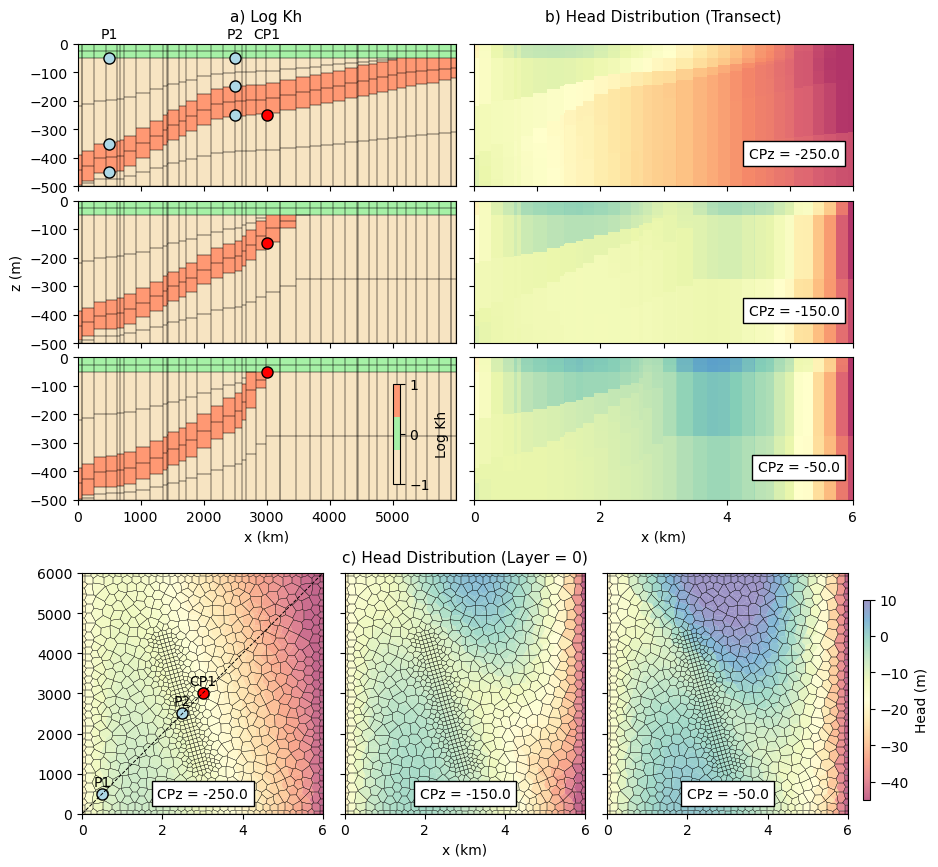

In [117]:
%run ./figures.ipynb
figure5(P, models = pinchout_models, X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)

### Pinchout - 100 simulations

In [12]:
options = np.linspace(-250, 0, 100) # control point z values
    
heads_PO = []
for i in range(len(options)): 
    print(i)
    M = Model('PO', P, plan = 'vor', transect = 'con') # Create flow model  
    P.control_points = (['CP1', 'control', 3000, 3000, options[i], -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
    P.data, P.strat = functions.prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = functions.create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    results = M.write_run_model(P, period = 'Steady', ic_array = P.strt)  
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = results[0], results[1], results[2], results[-1]
    heads_PO.append((M.head_ss))


0
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.433543
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.403699
1
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.549822
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.296652
2
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.418763
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.388122
3
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.419589
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.520948
4
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.421486
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.3598
5
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.409742
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.277466
6
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.551864
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.380474
7
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.417057
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.795151
8
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.44818
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.473383
9
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.418453
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.3167
10
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.42127
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.02281
11
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.421496
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.763509
12
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.468977
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.274895
13
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.438431
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.273585
14
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.417943
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.016816
15
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.490453
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.153101
16
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.433793
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.871693
17
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.436631
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.951408
18
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.428888
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.952657
19
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.561514
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.525536
20
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.611283
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.983804
21
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.558364
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.596788
22
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.42725
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.784354
23
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.458229
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.198756
24
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.487941
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.828407
25
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.502813
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.860001
26
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.623696
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.459975
27
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  1.476454
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.986192
28
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.435337
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.267348
29
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.617437
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.796385
30
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.448447
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.653731
31
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.444986
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.814694
32
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.450137
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.695092
33
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.549314
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.813352
34
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.445798
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.598854
35
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.479989
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.757868
36
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.432391
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.712994
37
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.426035
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.391638
38
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.500996
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.624444
39
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.433621
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.322972
40
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.435707
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.637981
41
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.478309
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.643021
42
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.470181
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.256488
43
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.435486
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.323893
44
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.446928
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.422831
45
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.578488
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.265039
46
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.427681
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.151412
47
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.597193
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.240093
48
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.432489
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.32278
49
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.601382
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.397891
50
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.447154
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.422447
51
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.708045
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.506338
52
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.438264
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.109559
53
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.810299
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.556256
54
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.455202
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.033917
55
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.447706
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.44714
56
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.451817
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.146377
57
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.460157
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.53194
58
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.436138
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.283848
59
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.50916
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.424964
60
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.446483
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.119038
61
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.445058
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.138639
62
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.485668
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.679147
63
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.619953
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.866302
64
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.655385
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.220593
65
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.590349
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.691304
66
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.977888
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.812063
67
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.678513
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.721003
68
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.467157
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.531936
69
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.439573
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.801159
70
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.503148
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.402022
71
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.429119
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.203316
72
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.460627
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.368641
73
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.622267
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.279331
74
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.465386
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.367822
75
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.441398
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.343618
76
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.431514
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.518073
77
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.429377
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.464733
78
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.4804
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.67017
79
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.509873
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.264542
80
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.456172
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.052291
81
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.428465
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  3.80288
82
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.441239
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.545018
83
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.524735
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.004924
84
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.427603
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.155704
85
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.454932
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  3.748325
86
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.444916
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  3.883377
87
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.429616
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  3.951498
88
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.558453
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.045504
89
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.418617
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.02124
90
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.439233
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  3.872177
91
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.426951
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.190416
92
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.593309
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  3.913863
93
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.489001
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  3.919139
94
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.425788
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.004445
95
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.450624
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.002809
96
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.428642
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.000551
97
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.437678
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.275123
98
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.592417
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.087825
99
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.418905
   Writing simulation and gwf for  PO  ...
Period =  Steady 
   Model success =  True
   run_time =  3.856414


In [13]:
layer = 0

stacked = []
for n in range(100):
    heads_disv = -1e30 * np.ones_like(M.idomain, dtype=float) 
    for i, h in enumerate(heads_PO[n][0][0]):
        if math.isnan(h) == False: 
            heads_disv[M.cellid_disu==i] = h        
    stacked.append(heads_disv[layer])
std_PO = np.std(np.array(stacked), axis = 0)

### Fault - 100 realisations

In [25]:
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = True)  
P.hk = [1, 2, 0.01, 5] 
P.vk = [i/10 for i in P.hk]

options = np.linspace(0, 200, 100) # Fault displacement

data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "fault_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")

P.control_points = ([])
P.fault_max_disp = 100.    # Was 200
P.minor_axis = 1000        # Fault_influence - orthogonal to fault
P.fault_center = [P.fx1 + (P.fx2 - P.fx1)/2, P.fy1 + (P.fy2 - P.fy1)/2, -400]
P.fault_slip_vector=[0,0,1]
        
heads_FD = []
for i in range(len(options)):
    print(i)
    N = Model('FD', P, plan = 'vor', transect = 'con') # Create flow model  
    P.fault_max_disp = options[i]
    P.data, P.strat = functions.prepare_geomodel_loopshowcase(P, data, strat, include_fault = True)   # Prepare geomodel inputs
    P.geomodel = functions.create_geomodel_loopshowcase(P, include_fault = True) # Make geomodel
    N.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    N.create_prop_arrays(P)                                     # Create K arrays
    N.create_flow_package_arrays(P)                             # Create flow packages
    results = N.write_run_model(P, period = 'Steady', ic_array = P.strt)  
    N.gwf, N.head_ss, N.obs_ss, N.runtime_ss = results[0], results[1], results[2], results[-1]
    heads_FD.append(N.head_ss)


                          projected onto fault surface estimating from fault normal


0
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.641524
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  10.520425
1
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.586333
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.393928
2
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.53405
   Writing simulation and gwf for  FD  ...


Period =  Steady 
   Model success =  True
   run_time =  8.447818
3
Fault included!


                          projected onto fault surface estimating from fault normal
C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating lithology and discretisation arrays for  FD  ...
   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.823618
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.096751
4
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.677786
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.510265
5
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.564671
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.635269
6
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.55536
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.938678
7
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.593665
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.490037
8
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.552592
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.888335
9
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.91237
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.385786
10
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.819709
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.147802
11
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.819308
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.736457
12
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.543784
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.499967
13
Fault included!


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating lithology and discretisation arrays for  FD  ...
   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.742752
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.944155
14
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.581606
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.332913
15
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.690831
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.327421
16
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.561833
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.834088
17
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.763514
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.846054
18
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.538709
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.217579
19
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.620362
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.150733
20
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.626266
   Writing simulation and gwf for  FD  ...


Period =  Steady 
   Model success =  True
   run_time =  8.567281
21


                          projected onto fault surface estimating from fault normal
C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
   Creating lithology and discretisation arrays for  FD  ...
   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.618022
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.171453
22
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.638021
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.760582
23
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.662198
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.891424
24
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.568235
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.076687
25
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.552562
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.115511
26
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.552414
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.125158
27
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.797372
   Writing simulation and gwf for  FD  ...
Period =  Steady 
   Model success =  True
   run_time =  9.794881
28


                          projected onto fault surface estimating from fault normal
C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
   Creating lithology and discretisation arrays for  FD  ...
   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.556484
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.670725
29
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.702881
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.521759
30
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.727285
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.374836
31
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.807526
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.020207
32
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.704219
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.61707
33
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.760519
   Writing simulation and gwf for  FD  ...


Period =  Steady 
   Model success =  True
   run_time =  7.488667
34
Fault included!


                          projected onto fault surface estimating from fault normal
C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating lithology and discretisation arrays for  FD  ...
   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.744691
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.983774
35
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.786788
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.740325
36
Fault included!


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating lithology and discretisation arrays for  FD  ...
   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.692645
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.092034
37
Fault included!


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating lithology and discretisation arrays for  FD  ...
   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.822545
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.181105
38
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.781123
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.913731
39
Fault included!


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating lithology and discretisation arrays for  FD  ...
   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.699106
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.738196
40
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.715997
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.683562
41
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.749412
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.491534
42
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  1.334395
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.01691
43
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.683561
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.774078
44
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  1.041822
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.673275
45
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.705779
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.03287
46
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.591976
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.91895
47
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.700697
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.918144
48
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.637721
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.249
49
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.774148
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.849199
50
Fault included!


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating lithology and discretisation arrays for  FD  ...
   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.566553
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.860985
51
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.583464
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.793187
52
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.582182
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.144152
53
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.549794
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.798806
54
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.711152
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.906925
55
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.558278
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.996615
56
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.708219
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.534249
57
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.595074
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.490996
58
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.937891
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.442099
59
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.597996
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.05997
60
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.697168
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.583649
61
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.57283
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.028334
62
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.691699
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.966468
63
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.560863
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.777865
64
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.824189
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.199685
65
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.543014
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.586139
66
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.821737
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.781402
67
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.614616
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.51449
68
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.690892
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.309921
69
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.56227
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.466126
70
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.645475
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.925331
71
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.541539
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.719894
72
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.545746
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.09839
73
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.663803
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.611504
74
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.589888
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.171157
75
Fault included!


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating lithology and discretisation arrays for  FD  ...
   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.544688
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.102037
76
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.542698
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.960526
77
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.536523
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.897986
78
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.539983
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.559276
79
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.682066
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.042036
80
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.548413
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.522794
81
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.547787
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.835613
82
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.545773
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.933748
83
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.537775
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.815069
84
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.5317
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.670908
85
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.571885
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.670763
86
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.562932
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.558158
87
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.543199
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.674459
88
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.549519
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.028948
89
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.559013
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.947861
90
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.756301
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.921167
91
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.698206
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.720699
92
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.685954
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.860261
93
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.724936
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.117507
94
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.531998
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.106254
95
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.619439
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.222288
96
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.532598
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.026779
97
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.806612
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.904421
98
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.563433
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.1659
99
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.717887
   Writing simulation and gwf for  FD  ...
Period =  Steady 
   Model success =  True
   run_time =  7.558538


In [26]:
# FAULT
stacked = []
for n in range(100):
    heads_disv = -1e30 * np.ones_like(N.idomain, dtype=float) 
    for i, h in enumerate(heads_FD[n][0][0]):
        if math.isnan(h) == False: 
            heads_disv[N.cellid_disu==i] = h        
    stacked.append(heads_disv[layer])
std_FD = np.std(np.array(stacked), axis = 0)

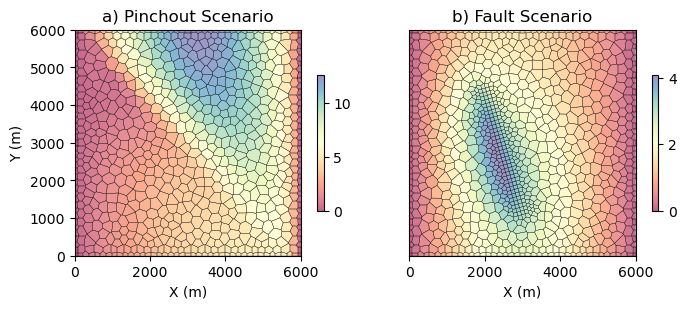

In [54]:
%run ./figures.ipynb                   # Contains functions to produce figures
figure7(P, std_PO, std_FD)

In [28]:
max(heads_FD[0][0][0] - heads_FD[99][0][0])

np.float64(12.447620173087758)

In [49]:
1772/500

3.544